In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/PAC/cnn

/content/drive/MyDrive/Github/PAC/cnn


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
import matplotlib.pyplot as plt
from src import visualize as vs

## Dice Loss

De acordo com [Loss odyssey](https://doi.org/10.1016/j.media.2021.102035), a função de perda Dice $L_{Dice}$ pode ser definida como
$$L_{Dice} = 1 - \dfrac{2\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c s_i^c}{\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c + \sum_{c=1}^{C}\sum_{i=1}^{N}s_i^c},$$
onde $N$ é o número de voxels da imagem, $C$ são as classes, $g_i^c$ é o ground truth e $s_i^c$ a propabilidade do voxel $i$ pertencer à classe $c$ de acordo com o modelo. Considerando o ground truth 
$$g_i^c = \left\{
\begin{array}{rl}
    1, &\text{se pertencer à classe}\\
    0, &\text{se não}
\end{array}\right.,$$
para classificação binária,
$$\begin{align}
L_{Dice} 
&= 1 - \dfrac{2\left[
    \sum_{i=1}^{N_{TP}} \hat{y}_i + \sum_{i=1}^{N_{TN}} (1 - \hat{y}_i)
\right]}{
    \left(\sum_{i=1}^{N_{TP}} 1 + \sum_{i=1}^{N_{TN}} 1\right) + 
    \left[\sum_{i=1}^N \hat{y}_i + \sum_{i=1}^N (1 - \hat{y}_i)\right]
}\\
&= 1 - \dfrac{2\left[
    \sum_{i=1}^{N_{TP}} \hat{y}_i + \sum_{i=1}^{N_{TN}} (1 - \hat{y}_i)
\right]}{
    N + \sum_{i=1}^N (\hat{y}_i + 1 - \hat{y}_i)
}\\
&= 1 - \dfrac{2\left[
    \sum_{i=1}^{N_{TP}} \hat{y}_i + \sum_{i=1}^{N_{TN}} (1 - \hat{y}_i)
\right]}{
    N + \sum_{i=1}^N 1
}\\
&= 1 - \dfrac{\sum_{i=1}^{N_{TP}} \hat{y}_i + \sum_{i=1}^{N_{TN}} (1 - \hat{y}_i)}{N}\\
\end{align}$$
onde $N_{TP}$ consiste na região de verdadeiro-positivo, $N_{TN}$ a região de verdadeiro-negativo ($N = N_{TP} + N_{TN}$) e $\hat{y}$ é a probabilidade de um píxel ser classificado como verdadeiro de acordo com a predição do modelo ($0 \le \hat{y} \le 1$).

In [ ]:
class DiceLoss(Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(tf.where(y_true == 0, 1-y_pred, y_pred), axis=(-1, -2, -3))

In [ ]:
%%time
dataset = (x_train, y_train), (x_test, y_test) = data.load_dataset(grayscale=True, augmentation=True)

CPU times: user 637 ms, sys: 301 ms, total: 939 ms
Wall time: 28.2 s


In [ ]:
unet = aimodel.UNet('unet_dice_test', dataset).load(compile=False) #.build((16, 32, 64))
unet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=DiceLoss(),
    metrics=[aimodel.amape]
)

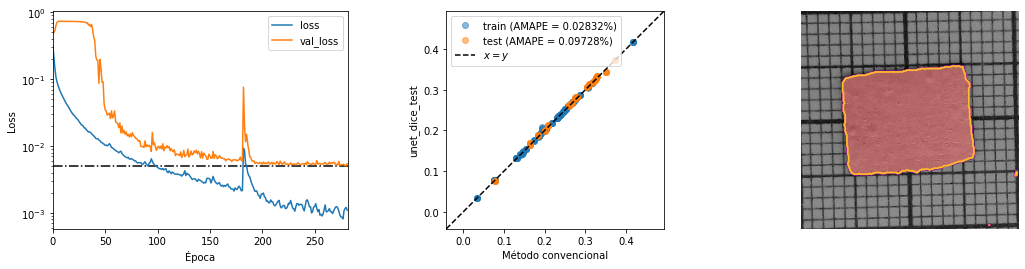

,epoch,amape,loss,val_amape,val_loss
165,165,0.037822,0.002509,0.072794,0.006051
280,279,0.032579,0.001210,0.074422,0.005062


In [ ]:
history = unet.fit(100, x_train.shape[0]//6, period=5)

In [ ]:
import pandas as pd
logs = pd.read_csv(f'saves/unet_dice_test/logs.csv')
logs.head()

,epoch,amape,loss,val_amape,val_loss
0,0,7.457460,0.319574,10.565241,0.490531
1,1,5.723400,0.213796,11.213580,0.495368
2,2,4.090270,0.144355,15.121113,0.533124
3,3,3.389943,0.106746,24.928764,0.638511
4,4,3.168733,0.091229,30.338264,0.704630


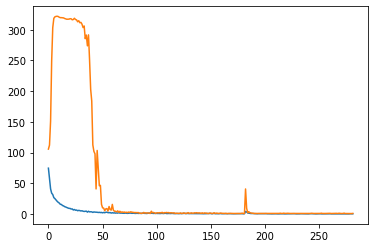

In [ ]:
plt.plot(logs.amape*10)
plt.plot(logs.val_amape*10)

(-1.8869067071937031, 10.0)

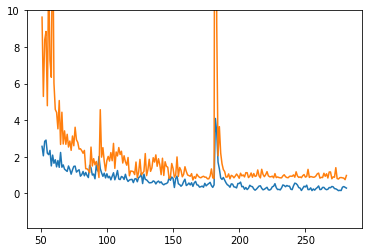

In [ ]:
loc = logs.epoch > 50
plt.plot(logs[loc].amape*10)
plt.plot(logs[loc].val_amape*10)
plt.ylim(top=10)

(-0.0029338644468226457, 0.02)

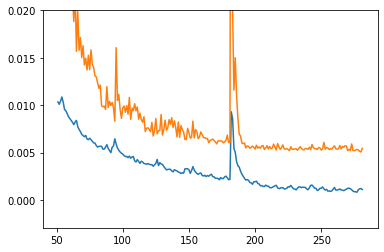

In [ ]:
loc = logs.epoch > 50
plt.plot(logs[loc].loss)
plt.plot(logs[loc].val_loss)
plt.ylim(top=0.02)

# TopK Loss

De forma generalizada, a função de perda TopK é definida como
$$
L_{TopK} = -\frac{1}{N} \sum^C_{c=1} \sum_{i \in \mathbf{k}} g_i^c \ln s_i^c,
$$
onde $\mathbf{K}$ representa os $k\%$ piores píxels. Assim, para classificação binária, a função se reduz a
$$
L_{TopK} = -\frac{1}{N} \sum_{i\,\in\,(\mathbf{k}\,\cup\,G)} \ln \hat{y}_i
$$


In [54]:
class TopK(Loss):
    def __init__(self, k):
        super().__init__()
        assert 0 <= k <= 1
        self.k = k
    
    @tf.function
    def _k_th_log(self, gs):
        g, s = tf.unstack(gs, axis=0) # g.shape == s.shape == [height, width, 1]
        y = s[tf.cast(g, tf.bool)] # in G
        th = tf.cast(tf.cast(len(y), tf.float32)*self.k, tf.int32) # k's threshold
        ks_elements = tf.sort(y)[:th] # in K
        N = tf.cast(tf.reduce_prod(g.shape), tf.float32) # N == height*width
        return tf.cast(tf.reduce_sum(tf.math.log(ks_elements)), tf.float32)/N
    
    @tf.function
    def call(self, y_true, y_pred):
        gs = tf.stack((y_true, y_pred), axis=1) # gs.shape == [n_batch, 2, ...]
        return -tf.map_fn(self._k_th_log, gs, fn_output_signature=tf.float32)

# Boundary-based metric

In [4]:
from src.data import load_all
from scipy.interpolate import splprep, splev

In [5]:
images, masks = load_all()
images.shape, masks.shape

(TensorShape([63, 256, 256, 1]), TensorShape([63, 256, 256, 1]))

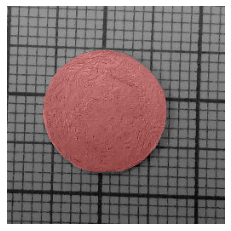

In [6]:
i = np.random.randint(images.shape[0])
vs.plot_label(images[i], masks[i])

In [38]:
def get_boundary(masks):
    pad = tf.pad(masks, ((0, 0), (0, 1), (0, 1), (0, 0)))
    dy = masks - pad[:, 1:, :-1]
    dx = masks - pad[:, :-1, 1:]
    return tf.reduce_any(tf.cast(tf.stack((dy, dx)), tf.bool), axis=0)    

edges = get_boundary(masks)
del_G = edges[i, ..., 0].numpy()

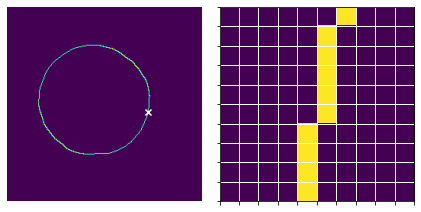

In [36]:
fig = plt.figure(figsize=(6, 3))

X, Y = np.meshgrid(np.arange(edges.shape[2]), np.arange(edges.shape[1]))
j = np.random.randint(np.sum(del_G))
x, y = X[del_G][j], Y[del_G][j]

fig.add_subplot(121)
vs.plot_image(del_G)
plt.scatter(x, y, marker='x', c='w')

ax = fig.add_subplot(122)
ax.imshow(del_G[y-5:y+5, x-5:x+5])
ax.set_xticks(np.arange(-0.5, 10), [])
ax.set_yticks(np.arange(-0.5, 10), [])
ax.grid(True, color='w', linestyle='-', linewidth=1)

fig.tight_layout()

In [40]:
def random_segmentation(shape, n, k=500):
    r_max = np.min(shape)/2
    d_theta = 2*np.pi/n
    theta = np.arange(0, 2*np.pi, d_theta)
    rho = np.random.randint(0, r_max, n)
    x = rho*np.cos(theta) + shape[1]/2
    y = rho*np.sin(theta) + shape[0]/2
    tck, u = splprep((np.r_[x, x[0]], np.r_[y, y[0]]), s=0, per=True)
    xi, yi = splev(np.linspace(0, 1, k), tck)
    X, Y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    Z = np.zeros(shape)
    for xn, yn in zip(xi, yi):
        Z[(X == int(xn)) & (Y == int(yn))] = 1
    return Z.astype(bool)

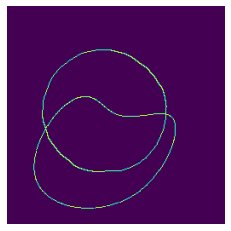

In [45]:
fig, ax = plt.subplots()
del_S = random_segmentation(del_G.shape, 5)
vs.plot_image(del_G | del_S)

plt.show()